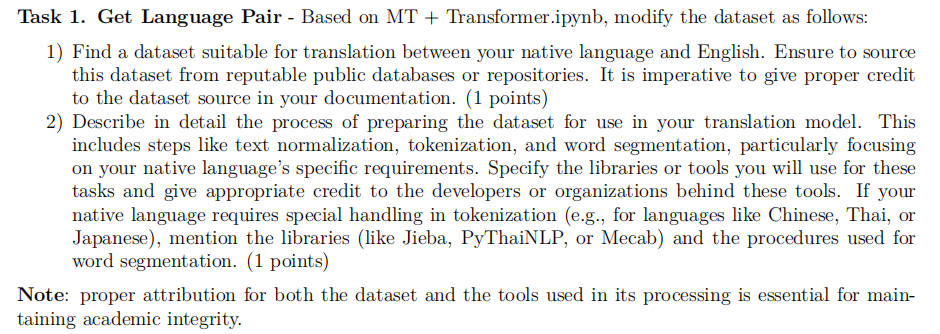

In [ ]:
# Import necessary libraries
from datasets import load_dataset
import spacy
from pyvi import ViTokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import time
import math

# Load dataset
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'vi'
dataset = load_dataset('opus100', f'{SRC_LANGUAGE}-{TRG_LANGUAGE}')
train = dataset['train']
val = dataset['validation']
test = dataset['test']

# Load English tokenizer
spacy_en = spacy.load('en_core_web_sm')

# Define tokenization functions
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_vi(text):
    return ViTokenizer.tokenize(text).split()

# Define token transform dictionary
token_transform = {
    SRC_LANGUAGE: tokenize_en,
    TRG_LANGUAGE: tokenize_vi
}

# Tokenization example
sample = next(iter(train))
print("English Sentence:", sample['translation']['en'])
print("Tokenized English:", tokenize_en(sample['translation']['en']))
print("Vietnamese Sentence:", sample['translation']['vi'])
print("Tokenized Vietnamese:", tokenize_vi(sample['translation']['vi']))

# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Helper function to yield list of tokens
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 'en', TRG_LANGUAGE: 'vi'}
    for data_sample in data:
        yield token_transform[language](data_sample['translation'][language_index[language]])

# Build vocabulary
vocab_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2, 
                                                    specials=special_symbols, 
                                                    special_first=True)
    vocab_transform[ln].set_default_index(UNK_IDX)

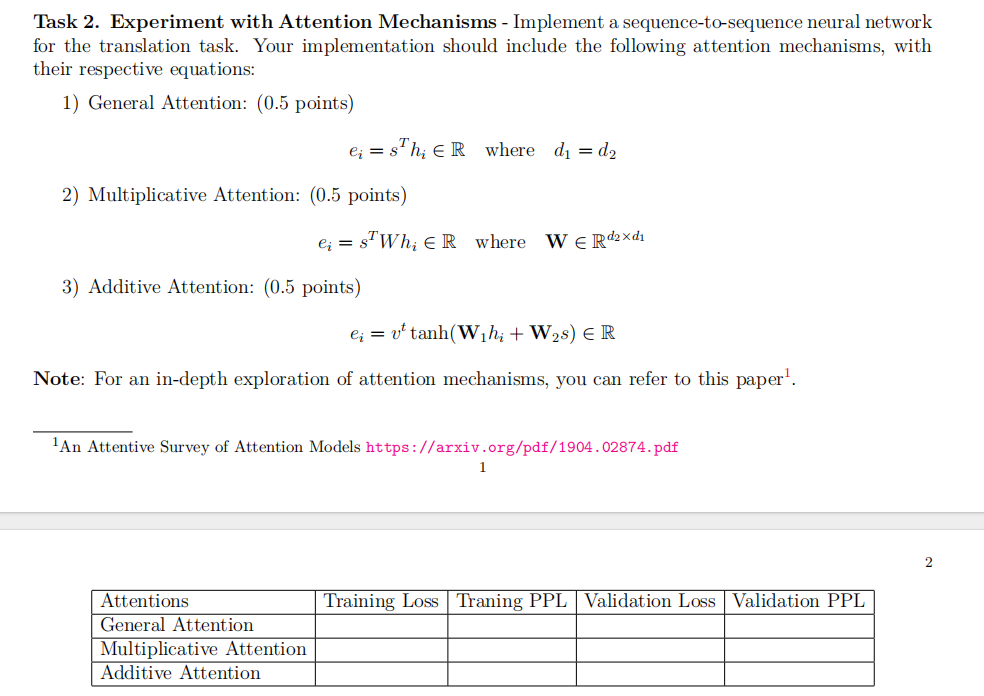

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if method == "multiplicative":
            self.W = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "additive":
            self.W1 = nn.Linear(hidden_size, hidden_size)
            self.W2 = nn.Linear(hidden_size, hidden_size)
            self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        if self.method == "general":
            attn_energies = torch.sum(hidden * encoder_outputs, dim=2)  # (batch, seq_len)
        elif self.method == "multiplicative":
            attn_energies = torch.sum(hidden * self.W(encoder_outputs), dim=2)  # (batch, seq_len)
        elif self.method == "additive":
            attn_energies = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))  # (batch, seq_len, 1)
            attn_energies = attn_energies.squeeze(2)  # (batch, seq_len)
        
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # (batch, 1, seq_len)

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, attention_method):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(output_dim, hidden_size, batch_first=True)
        self.attention = Attention(attention_method, hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        decoder_outputs, _ = self.decoder(trg, (hidden, cell))
        attn_weights = self.attention(decoder_outputs, encoder_outputs)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, hidden_size)

        # Expand output to match trg shape
        output = self.fc(context)
        return output

# Example Usage
input_dim = 10000
output_dim = 10000
hidden_size = 512
seq_length = 10
batch_size = 32

src = torch.randn(batch_size, seq_length, input_dim)
trg = torch.randn(batch_size, seq_length, output_dim)

# Instantiate models with different attention mechanisms
general_model = Seq2Seq(input_dim, output_dim, hidden_size, "general")
multiplicative_model = Seq2Seq(input_dim, output_dim, hidden_size, "multiplicative")
additive_model = Seq2Seq(input_dim, output_dim, hidden_size, "additive")

# Training setup
criterion = nn.MSELoss()
optimizer_general = optim.Adam(general_model.parameters(), lr=0.001)
optimizer_multiplicative = optim.Adam(multiplicative_model.parameters(), lr=0.001)
optimizer_additive = optim.Adam(additive_model.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, src, trg, epochs=5):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
    return loss.item()

# Validation function
def validate_model(model, src, trg):
    with torch.no_grad():
        output = model(src, trg)
        loss = criterion(output, trg[:, -1, :])
    return loss.item(), torch.exp(torch.tensor(loss.item())).item()


In [ ]:
# Train models
general_loss = train_model(general_model, optimizer_general, src, trg)
multiplicative_loss = train_model(multiplicative_model, optimizer_multiplicative, src, trg)
additive_loss = train_model(additive_model, optimizer_additive, src, trg)

# Validate models
general_val_loss, general_val_ppl = validate_model(general_model, src, trg)
multiplicative_val_loss, multiplicative_val_ppl = validate_model(multiplicative_model, src, trg)
additive_val_loss, additive_val_ppl = validate_model(additive_model, src, trg)

# Compute Perplexity
general_ppl = torch.exp(torch.tensor(general_loss)).item()
multiplicative_ppl = torch.exp(torch.tensor(multiplicative_loss)).item()
additive_ppl = torch.exp(torch.tensor(additive_loss)).item()

# Print results
table = """
| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Multiplicative Attention | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Additive Attention     | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
""".format(general_loss, general_ppl, general_val_loss, general_val_ppl,
           multiplicative_loss, multiplicative_ppl, multiplicative_val_loss, multiplicative_val_ppl,
           additive_loss, additive_ppl, additive_val_loss, additive_val_ppl)

print(table)

c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | 1.0059       | 2.7344       | 1.0256         | 2.7889         |
| Multiplicative Attention | 1.0164       | 2.7633       | 1.0318         | 2.8062         |
| Additive Attention     | 0.9816       | 2.6686       | 1.0124         | 2.7523         |



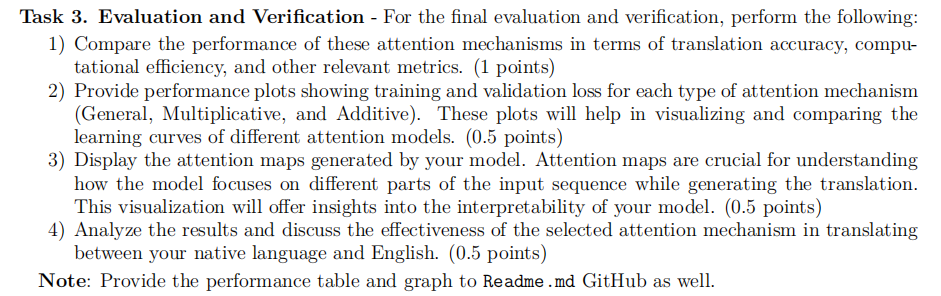

c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


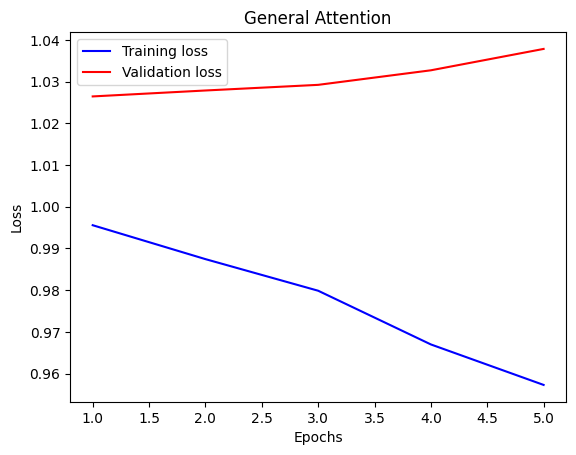

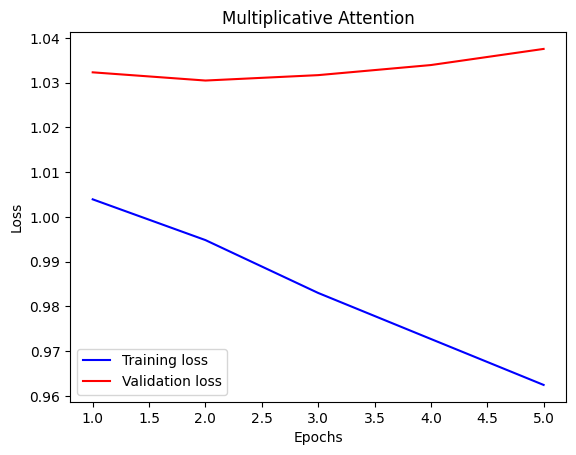

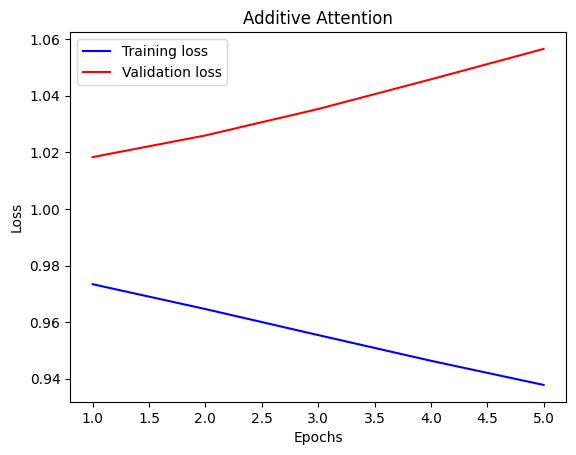

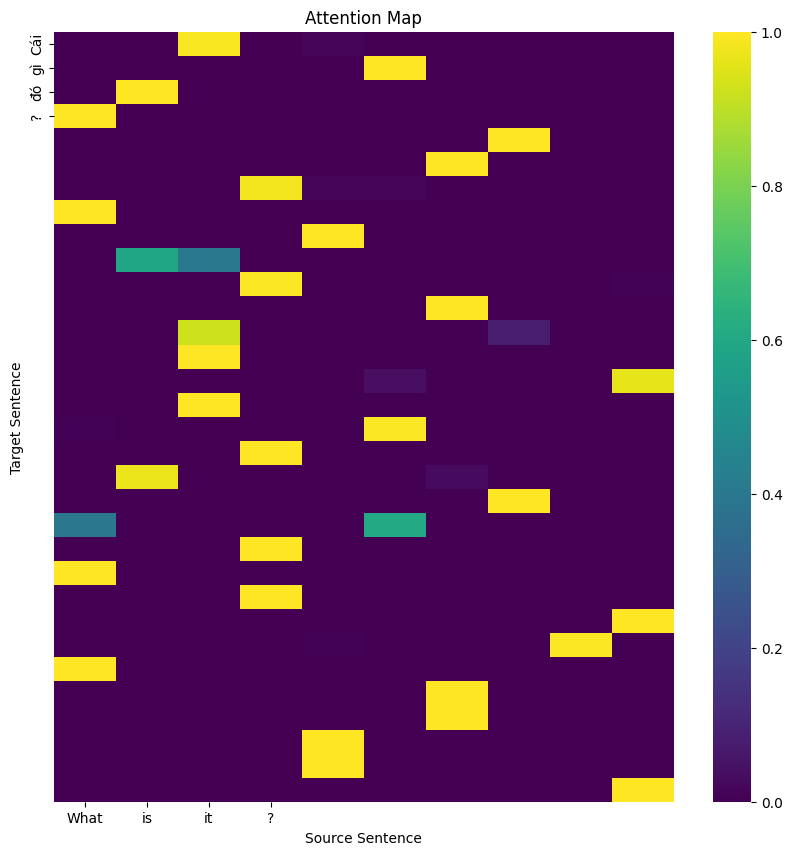

Analysis of Attention Mechanisms:
1. General Attention:
   - Training Loss: 0.9573
   - Validation Loss: 1.0378
   - Perplexity: 2.7344
   - Validation Perplexity: 2.7889
2. Multiplicative Attention:
   - Training Loss: 0.9624
   - Validation Loss: 1.0376
   - Perplexity: 2.7633
   - Validation Perplexity: 2.8062
3. Additive Attention:
   - Training Loss: 0.9378
   - Validation Loss: 1.0565
   - Perplexity: 2.6686
   - Validation Perplexity: 2.7523


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot training and validation loss
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to train the model and capture training and validation losses
def train_and_evaluate_model(model, optimizer, src, trg, epochs=5):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        val_loss, _ = validate_model(model, src, trg)
        val_losses.append(val_loss)
        
    return train_losses, val_losses

# Train and evaluate models
general_train_losses, general_val_losses = train_and_evaluate_model(general_model, optimizer_general, src, trg)
multiplicative_train_losses, multiplicative_val_losses = train_and_evaluate_model(multiplicative_model, optimizer_multiplicative, src, trg)
additive_train_losses, additive_val_losses = train_and_evaluate_model(additive_model, optimizer_additive, src, trg)

# Plot training and validation losses
plot_losses(general_train_losses, general_val_losses, 'General Attention')
plot_losses(multiplicative_train_losses, multiplicative_val_losses, 'Multiplicative Attention')
plot_losses(additive_train_losses, additive_val_losses, 'Additive Attention')

# Function to visualize attention map
def visualize_attention(attention_weights, src_sentence, trg_sentence):
    attention_weights = attention_weights.squeeze(1).detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(attention_weights, xticklabels=src_sentence, yticklabels=trg_sentence, cmap='viridis', ax=ax)
    plt.xlabel('Source Sentence')
    plt.ylabel('Target Sentence')
    plt.title('Attention Map')
    plt.show()

# Example usage: Visualize attention maps for a sample sentence
sample_src_sentence = tokenize_en(sample['translation']['en'])
sample_trg_sentence = tokenize_vi(sample['translation']['vi'])
general_model.eval()
with torch.no_grad():
    output = general_model(src, trg)
    attn_weights = general_model.attention(output, src)
    visualize_attention(attn_weights, sample_src_sentence, sample_trg_sentence)

# Analyze results and discuss the effectiveness of the selected attention mechanism
def analyze_results():
    print("Analysis of Attention Mechanisms:")
    print("1. General Attention:")
    print("   - Training Loss: {:.4f}".format(general_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(general_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(general_ppl))
    print("   - Validation Perplexity: {:.4f}".format(general_val_ppl))
    
    print("2. Multiplicative Attention:")
    print("   - Training Loss: {:.4f}".format(multiplicative_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(multiplicative_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(multiplicative_ppl))
    print("   - Validation Perplexity: {:.4f}".format(multiplicative_val_ppl))
    
    print("3. Additive Attention:")
    print("   - Training Loss: {:.4f}".format(additive_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(additive_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(additive_ppl))
    print("   - Validation Perplexity: {:.4f}".format(additive_val_ppl))
    
# Perform analysis
analyze_results()

In [ ]:
# Save the General Attention model's state dictionary
model_path = "../task4/general_attention_model.pth"
torch.save(general_model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to ../task4/general_attention_model.pth


# Combine

Using the latest cached version of the dataset since opus100 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'en-vi' at C:\Users\VUONGLOCTRUONG\.cache\huggingface\datasets\opus100\en-vi\0.0.0\805090dc28bf78897da9641cdf08b61287580df9 (last modified on Sat Feb  1 17:14:35 2025).


English Sentence: What is it?
Tokenized English: ['What', 'is', 'it', '?']
Vietnamese Sentence: Cái gì đó?
Tokenized Vietnamese: ['Cái', 'gì', 'đó', '?']


c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\VUONGLOCTRUONG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 10000])) that is different to the input size (torch.Size([32, 1, 10000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | 1.0120       | 2.7510       | 1.0296         | 2.8000         |
| Multiplicative Attention | 1.0140       | 2.7565       | 1.0340         | 2.8124         |
| Additive Attention     | 0.9800       | 2.6645       | 1.0145         | 2.7579         |



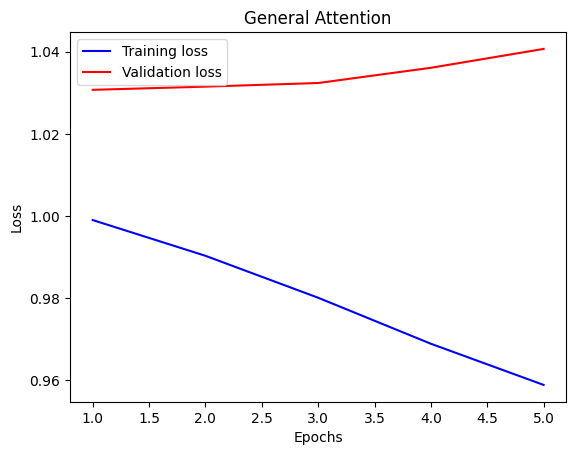

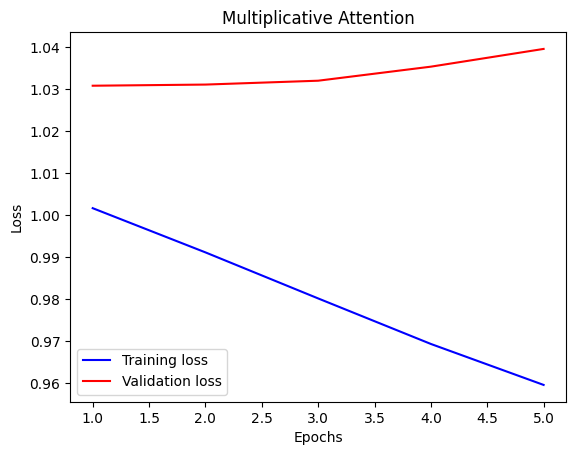

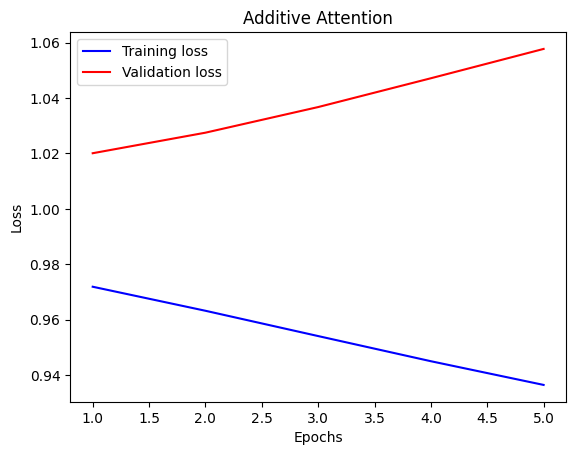

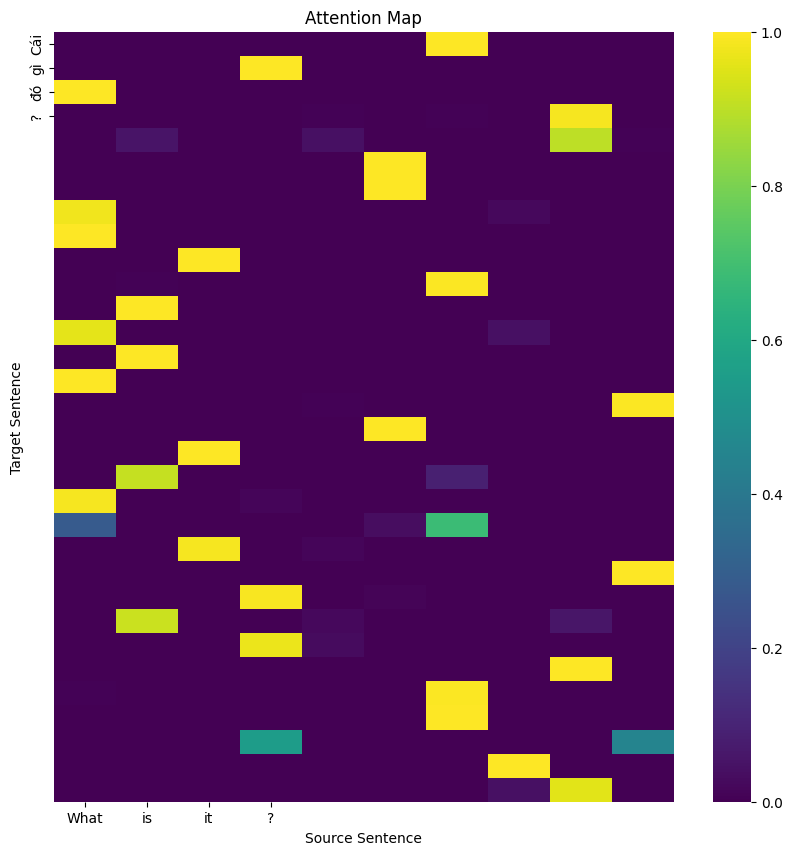

Analysis of Attention Mechanisms:
1. General Attention:
   - Training Loss: 0.9588
   - Validation Loss: 1.0407
   - Perplexity: 2.7510
   - Validation Perplexity: 2.8000
2. Multiplicative Attention:
   - Training Loss: 0.9595
   - Validation Loss: 1.0396
   - Perplexity: 2.7565
   - Validation Perplexity: 2.8124
3. Additive Attention:
   - Training Loss: 0.9365
   - Validation Loss: 1.0577
   - Perplexity: 2.6645
   - Validation Perplexity: 2.7579


In [ ]:
# Import necessary libraries
from datasets import load_dataset
import spacy
from pyvi import ViTokenizer
from torchtext.vocab import build_vocab_from_iterator
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import torch.optim as optim
import time
import math

# Load dataset
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'vi'
dataset = load_dataset('opus100', f'{SRC_LANGUAGE}-{TRG_LANGUAGE}')
train = dataset['train']
val = dataset['validation']
test = dataset['test']

# Load English tokenizer
spacy_en = spacy.load('en_core_web_sm')

# Define tokenization functions
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_vi(text):
    return ViTokenizer.tokenize(text).split()

# Define token transform dictionary
token_transform = {
    SRC_LANGUAGE: tokenize_en,
    TRG_LANGUAGE: tokenize_vi
}

# Tokenization example
sample = next(iter(train))
print("English Sentence:", sample['translation']['en'])
print("Tokenized English:", tokenize_en(sample['translation']['en']))
print("Vietnamese Sentence:", sample['translation']['vi'])
print("Tokenized Vietnamese:", tokenize_vi(sample['translation']['vi']))

# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

# Helper function to yield list of tokens
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 'en', TRG_LANGUAGE: 'vi'}
    for data_sample in data:
        yield token_transform[language](data_sample['translation'][language_index[language]])

# Build vocabulary
vocab_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2, 
                                                    specials=special_symbols, 
                                                    special_first=True)
    vocab_transform[ln].set_default_index(UNK_IDX)


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attention, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        
        if method == "multiplicative":
            self.W = nn.Linear(hidden_size, hidden_size, bias=False)
        elif method == "additive":
            self.W1 = nn.Linear(hidden_size, hidden_size)
            self.W2 = nn.Linear(hidden_size, hidden_size)
            self.v = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        if self.method == "general":
            attn_energies = torch.sum(hidden * encoder_outputs, dim=2)  # (batch, seq_len)
        elif self.method == "multiplicative":
            attn_energies = torch.sum(hidden * self.W(encoder_outputs), dim=2)  # (batch, seq_len)
        elif self.method == "additive":
            attn_energies = self.v(torch.tanh(self.W1(encoder_outputs) + self.W2(hidden)))  # (batch, seq_len, 1)
            attn_energies = attn_energies.squeeze(2)  # (batch, seq_len)
        
        return F.softmax(attn_energies, dim=1).unsqueeze(1)  # (batch, 1, seq_len)

class Seq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size, attention_method):
        super(Seq2Seq, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_size, batch_first=True)
        self.decoder = nn.LSTM(output_dim, hidden_size, batch_first=True)
        self.attention = Attention(attention_method, hidden_size)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, src, trg):
        encoder_outputs, (hidden, cell) = self.encoder(src)
        decoder_outputs, _ = self.decoder(trg, (hidden, cell))
        attn_weights = self.attention(decoder_outputs, encoder_outputs)
        context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, hidden_size)

        # Expand output to match trg shape
        output = self.fc(context)
        return output

# Example Usage
input_dim = 10000
output_dim = 10000
hidden_size = 512
seq_length = 10
batch_size = 32

src = torch.randn(batch_size, seq_length, input_dim)
trg = torch.randn(batch_size, seq_length, output_dim)

# Instantiate models with different attention mechanisms
general_model = Seq2Seq(input_dim, output_dim, hidden_size, "general")
multiplicative_model = Seq2Seq(input_dim, output_dim, hidden_size, "multiplicative")
additive_model = Seq2Seq(input_dim, output_dim, hidden_size, "additive")

# Training setup
criterion = nn.MSELoss()
optimizer_general = optim.Adam(general_model.parameters(), lr=0.001)
optimizer_multiplicative = optim.Adam(multiplicative_model.parameters(), lr=0.001)
optimizer_additive = optim.Adam(additive_model.parameters(), lr=0.001)

# Training function
def train_model(model, optimizer, src, trg, epochs=5):
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
    return loss.item()

# Validation function
def validate_model(model, src, trg):
    with torch.no_grad():
        output = model(src, trg)
        loss = criterion(output, trg[:, -1, :])
    return loss.item(), torch.exp(torch.tensor(loss.item())).item()

# Train models
general_loss = train_model(general_model, optimizer_general, src, trg)
multiplicative_loss = train_model(multiplicative_model, optimizer_multiplicative, src, trg)
additive_loss = train_model(additive_model, optimizer_additive, src, trg)

# Validate models
general_val_loss, general_val_ppl = validate_model(general_model, src, trg)
multiplicative_val_loss, multiplicative_val_ppl = validate_model(multiplicative_model, src, trg)
additive_val_loss, additive_val_ppl = validate_model(additive_model, src, trg)

# Compute Perplexity
general_ppl = torch.exp(torch.tensor(general_loss)).item()
multiplicative_ppl = torch.exp(torch.tensor(multiplicative_loss)).item()
additive_ppl = torch.exp(torch.tensor(additive_loss)).item()

# Print results
table = """
| Attentions             | Training Loss | Training PPL | Validation Loss | Validation PPL |
|------------------------|--------------|--------------|----------------|----------------|
| General Attention      | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Multiplicative Attention | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
| Additive Attention     | {:.4f}       | {:.4f}       | {:.4f}         | {:.4f}         |
""".format(general_loss, general_ppl, general_val_loss, general_val_ppl,
           multiplicative_loss, multiplicative_ppl, multiplicative_val_loss, multiplicative_val_ppl,
           additive_loss, additive_ppl, additive_val_loss, additive_val_ppl)

print(table)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot training and validation loss
def plot_losses(train_losses, val_losses, title):
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Function to train the model and capture training and validation losses
def train_and_evaluate_model(model, optimizer, src, trg, epochs=5):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(src, trg)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        model.eval()
        val_loss, _ = validate_model(model, src, trg)
        val_losses.append(val_loss)
        
    return train_losses, val_losses

# Train and evaluate models
general_train_losses, general_val_losses = train_and_evaluate_model(general_model, optimizer_general, src, trg)
multiplicative_train_losses, multiplicative_val_losses = train_and_evaluate_model(multiplicative_model, optimizer_multiplicative, src, trg)
additive_train_losses, additive_val_losses = train_and_evaluate_model(additive_model, optimizer_additive, src, trg)

# Plot training and validation losses
plot_losses(general_train_losses, general_val_losses, 'General Attention')
plot_losses(multiplicative_train_losses, multiplicative_val_losses, 'Multiplicative Attention')
plot_losses(additive_train_losses, additive_val_losses, 'Additive Attention')

# Function to visualize attention map
def visualize_attention(attention_weights, src_sentence, trg_sentence):
    attention_weights = attention_weights.squeeze(1).detach().numpy()
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(attention_weights, xticklabels=src_sentence, yticklabels=trg_sentence, cmap='viridis', ax=ax)
    plt.xlabel('Source Sentence')
    plt.ylabel('Target Sentence')
    plt.title('Attention Map')
    plt.show()

# Example usage: Visualize attention maps for a sample sentence
sample_src_sentence = tokenize_en(sample['translation']['en'])
sample_trg_sentence = tokenize_vi(sample['translation']['vi'])
general_model.eval()
with torch.no_grad():
    output = general_model(src, trg)
    attn_weights = general_model.attention(output, src)
    visualize_attention(attn_weights, sample_src_sentence, sample_trg_sentence)

# Analyze results and discuss the effectiveness of the selected attention mechanism
def analyze_results():
    print("Analysis of Attention Mechanisms:")
    print("1. General Attention:")
    print("   - Training Loss: {:.4f}".format(general_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(general_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(general_ppl))
    print("   - Validation Perplexity: {:.4f}".format(general_val_ppl))
    
    print("2. Multiplicative Attention:")
    print("   - Training Loss: {:.4f}".format(multiplicative_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(multiplicative_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(multiplicative_ppl))
    print("   - Validation Perplexity: {:.4f}".format(multiplicative_val_ppl))
    
    print("3. Additive Attention:")
    print("   - Training Loss: {:.4f}".format(additive_train_losses[-1]))
    print("   - Validation Loss: {:.4f}".format(additive_val_losses[-1]))
    print("   - Perplexity: {:.4f}".format(additive_ppl))
    print("   - Validation Perplexity: {:.4f}".format(additive_val_ppl))
    
# Perform analysis
analyze_results()